# NLP EDA

Basically, exploration and modeling boil down to a single question:

How do we quantify our data/text

In this lesson, we'll explore answers to this question that will aid in visualization.

- word frequency (by label)
- ngrams
- word cloud
- sentiment analysis
- other common features

## Setup

Data is spam/ham text messages.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re

In [2]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

In [14]:
def clean(text):
    '''Simplified text cleaning function'''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [7]:
#acquire data from spam_db

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [5]:
# pd.read_csv('spam_clean.csv')

In [8]:
# pd.set_option('display.max_colwidth', -1)

In [9]:
# how many spam and ham observations do we have?

df.label.value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 130.6+ KB


In [12]:
# ' '.join(df[df.label == 'ham'].text)

In [15]:
# combine all messages in single string by label

ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [18]:
spam_words

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send a150 to rcv winner as a valued network customer you have been selected to receivea a900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only had your mobile 11 months or more u r entitled to update to the latest colour mobiles with camera for free call the mobile update co free on 08002986030 six chances to win cash from 100 to 20000 pounds txt csh11 and send to 87575 cost 150pday 6days 16 tsandcs apply reply hl 4 info urgent you have won a 1 week free membership in our a100000 prize jackpot txt the word claim to no 81010 tc wwwdbuknet lccltd pobox 4403ldnw1a7rw18 xxxmobilemovieclub to use your credit click the wap link in the next txt message or click here httpwap xxxmobilemovieclubcomnqj

## Exploration

Represent text as word frequencies.

In [19]:
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [20]:
ham_freq

i           2305
you         1837
to          1554
the         1118
a           1055
            ... 
daal        1   
parkin      1   
profit      1   
formsdon    1   
6months     1   
Length: 7555, dtype: int64

In [21]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['ham', 'spam', 'all']
word_counts.head()

,ham,spam,all
i,2305,45,2350
you,1837,287,2124
to,1554,686,2240
the,1118,204,1322
a,1055,376,1431


- What are the most frequently occuring words?
- Are there any words that uniquely identify a spam or ham message? I.e. words present in one type of message but not the other?

In [22]:
# sort by 'all'

word_counts.sort_values('all', ascending=False).head(20)

,ham,spam,all
i,2305,45,2350
to,1554,686,2240
you,1837,287,2124
a,1055,376,1431
the,1118,204,1322
u,986,147,1133
and,848,122,970
is,728,158,886
in,811,73,884
me,756,30,786


In [23]:
# sort by 'ham' and 'spam' columns
word_counts.sort_values(['ham', 'spam'], ascending=[True, False]).head(20)

,ham,spam,all
claim,0,113,113
prize,0,92,92
won,0,73,73
guaranteed,0,50,50
tone,0,48,48
18,0,43,43
awarded,0,38,38
a1000,0,35,35
150ppm,0,34,34
a2000,0,31,31


### Visualization

- ham vs spam count for 20 most common words
- ham vs spam proportion for 20 most common words

Text(0.5, 1.0, 'Ham vs Spam count for the top 20 most frequent words')

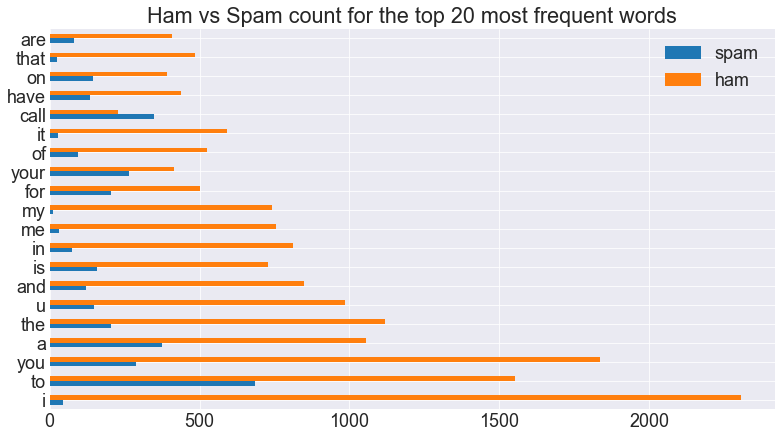

In [24]:
plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['spam', 'ham']].plot.barh()
plt.title('Ham vs Spam count for the top 20 most frequent words')

In [34]:
# (word_counts.sort_values('all', ascending=False)
#  .head(20)
#  .apply(lambda row: row/row['all'], axis = 1)
#  .drop(columns = 'all').
#  sort_values('spam')
#  .plot.barh(stacked = True, width = 1, ec = 'k')
# )

Text(0.5, 1.0, '% of spam vs ham for the most common 20 words')

<Figure size 1152x648 with 0 Axes>

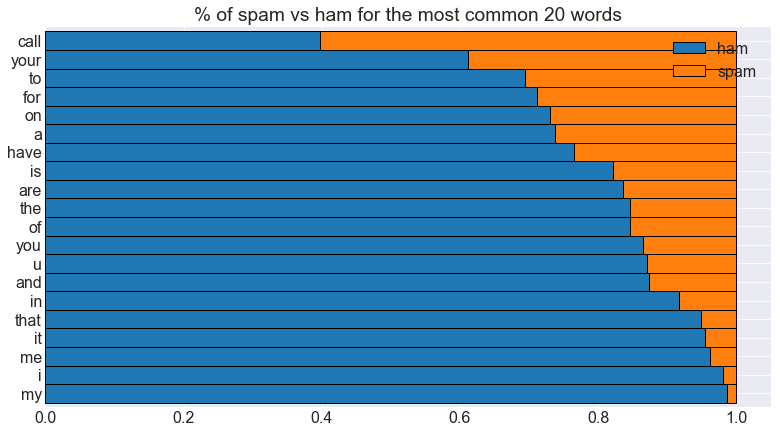

In [25]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'spam')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of spam vs ham for the most common 20 words')

## n-grams

**bigram**: combinations of 2 words

Represent text as combinations of 2 words

In [36]:
sentence = 'Today is tuesday, and the weather is nice.'

In [37]:
list(nltk.bigrams(sentence.split()))

[('Today', 'is'),
 ('is', 'tuesday,'),
 ('tuesday,', 'and'),
 ('and', 'the'),
 ('the', 'weather'),
 ('weather', 'is'),
 ('is', 'nice.')]

**Be Careful!** Make sure you are making bigrams out of *words*.

In [ ]:
# Don't do this!
# list(nltk.bigrams(sentence))

- what are the most common bigrams? spam bigrams? ham bigrams?
- visualize 20 most common bigrams, most common ham bigrams
- ngrams

Find the most common bigram and then find a representative text

Text(0.5, 1.0, 'Top 10 most common spam bigrams')

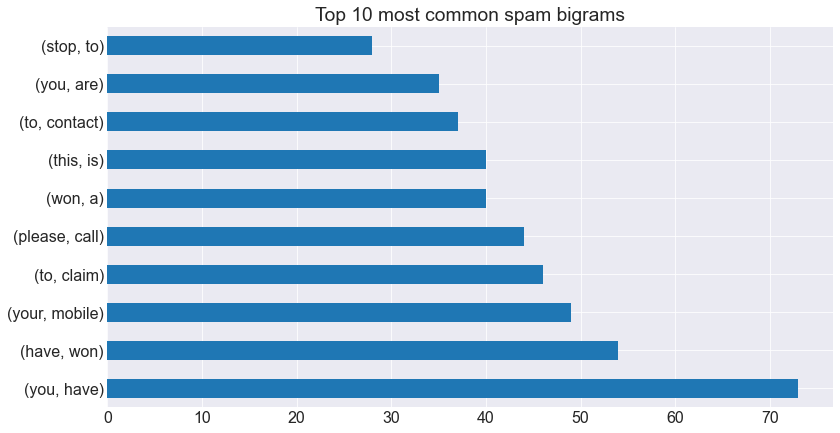

In [38]:
pd.Series(nltk.bigrams(spam_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common spam bigrams')

## Word Cloud

`python -m pip install --upgrade wordcloud`

documentation: https://amueller.github.io/word_cloud/

In [40]:
spam_words

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send a150 to rcv winner as a valued network customer you have been selected to receivea a900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only had your mobile 11 months or more u r entitled to update to the latest colour mobiles with camera for free call the mobile update co free on 08002986030 six chances to win cash from 100 to 20000 pounds txt csh11 and send to 87575 cost 150pday 6days 16 tsandcs apply reply hl 4 info urgent you have won a 1 week free membership in our a100000 prize jackpot txt the word claim to no 81010 tc wwwdbuknet lccltd pobox 4403ldnw1a7rw18 xxxmobilemovieclub to use your credit click the wap link in the next txt message or click here httpwap xxxmobilemovieclubcomnqj

(-0.5, 799.5, 599.5, -0.5)

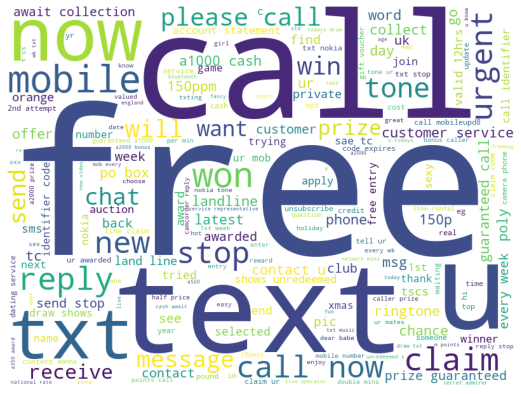

In [39]:
from wordcloud import WordCloud
img = WordCloud(background_color='white', width=800, height=600).generate(spam_words)
plt.imshow(img)
plt.axis('off')

## Other Common Features

Any NLP dataset will have domain specific features, for example: number of retweets, number of @mentions, number of upvotes, or mean time to respond to a support chat. In addition to these domain specific features, some common measures for a document are:

- character count
- word count
- sentence count
- stopword count
- unique word count
- punctuation count
- average word length
- average words per sentence
- word to stopword ratio

Create one or more of the above features and visualize it.

In [41]:
# add two new columns 'message_length' and 'word_count'

df['message_length'] = df.text.apply(len)

df['word_count'] = df.text.apply(clean).apply(str.split).apply(len)

df.head()

,label,text,message_length,word_count
id,,,,
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,20
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,28
3,ham,U dun say so early hor... U c already then say...,49,11
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,13


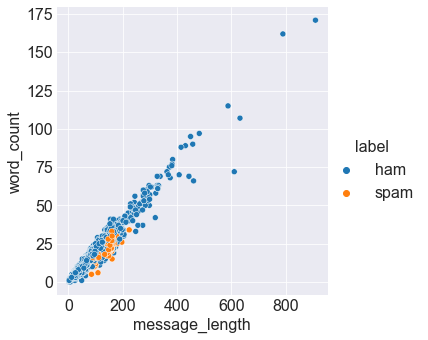

In [42]:
sns.relplot(data = df, x = 'message_length', y = 'word_count', hue = 'label')

In [43]:
df.groupby('label').message_length.agg(['mean', 'median'])

,mean,median
label,,
ham,71.023627,52
spam,138.866131,149


## Sentiment

A number indicating whether the document is positive or negative.

- knowledge-based + statistical approach
- relies on human-labelled data
    - combination of qualitative and quantitative methods
    - then empirically validate
- different models for diff domains (e.g. social media vs news)
- for social media
    - Afinn ([github](https://github.com/fnielsen/afinn) + [whitepaper](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf))
    - Vader ([github](https://github.com/cjhutto/vaderSentiment) + [whitepaper](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)) `nltk.sentiment.vader.SentimentIntensityAnalyzer`. Pre-trained sentiment analyzer (**V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner).)


From your terminal:
`python -c 'import nltk;nltk.download("vader_lexicon")'`

In [47]:
import nltk.sentiment

sia = nltk.sentiment.SentimentIntensityAnalyzer()
sia.polarity_scores('He is really good')

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}

In [50]:
sia.polarity_scores('He is really good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [51]:
sia.polarity_scores('He is REALLY good')

{'neg': 0.0, 'neu': 0.433, 'pos': 0.567, 'compound': 0.6028}

In [52]:
sia.polarity_scores('He is very good!!!')

{'neg': 0.0, 'neu': 0.424, 'pos': 0.576, 'compound': 0.6211}

In [54]:
sia.polarity_scores('The food is good but service is slow')

{'neg': 0.0, 'neu': 0.782, 'pos': 0.218, 'compound': 0.2382}

In [56]:
sia.polarity_scores('He is good :-)')

{'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.6369}

In [57]:
sia.polarity_scores('The food SUX')

{'neg': 0.618, 'neu': 0.382, 'pos': 0.0, 'compound': -0.4995}

Things that can influence Sentiment Score:
1. Punctuations. Can increase the intensity
2. Capitalization. Can increase the intensity
3. Degree modifiers
4. Conjunctions

It can handle Emojis and slangs

Apply this to the text message data

In [58]:
df['sentiment'] = df.text.apply(lambda doc: sia.polarity_scores(doc)['compound'])
df

,label,text,message_length,word_count,sentiment
id,,,,,
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,20,0.6249
1,ham,Ok lar... Joking wif u oni...,29,6,0.4767
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,28,0.7964
3,ham,U dun say so early hor... U c already then say...,49,11,0.0000
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,13,-0.1027
...,...,...,...,...,...
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",161,30,0.8805
5568,ham,Will Ì_ b going to esplanade fr home?,37,8,0.0000
5569,ham,"Pity, * was in mood for that. So...any other suggestions?",57,9,-0.2960


In [59]:
# is the mean and median values of sentiment score different for ham vs spam?
df.groupby('label').sentiment.agg(['mean','median'])

,mean,median
label,,
ham,0.152262,0.0000
spam,0.436018,0.6107


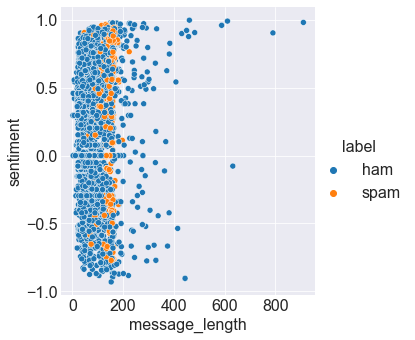

In [60]:
#plot message_length vs sentiment and hue by label
sns.relplot(data = df, x = 'message_length', y = 'sentiment', hue = 'label')

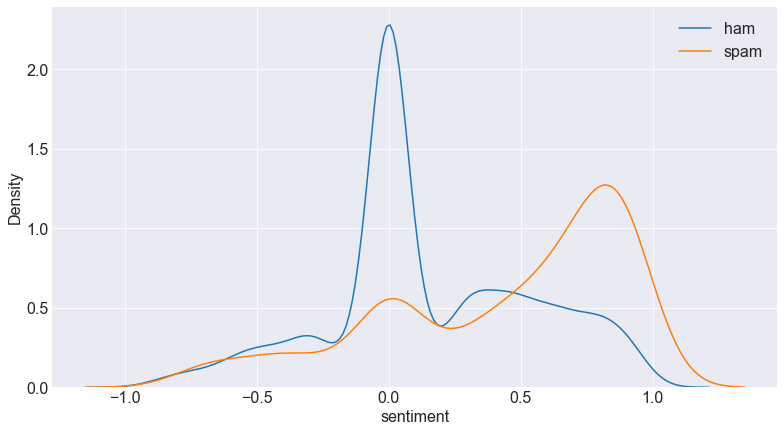

In [62]:
# is the distribution for sentiment different for ham vs spam
sns.kdeplot(df[df.label == 'ham'].sentiment, label = 'ham')
sns.kdeplot(df[df.label == 'spam'].sentiment, label = 'spam')
plt.legend(['ham', 'spam'])

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='message_length', ylabel='sentiment'>

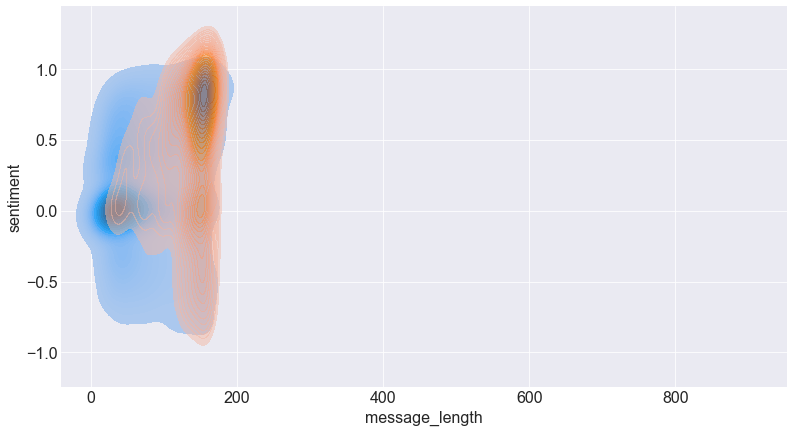

In [63]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(df[df.label == 'ham'].message_length,df[df.label == 'ham'].sentiment, levels = 30, shade = True )
sns.kdeplot(df[df.label == 'spam'].message_length,df[df.label == 'spam'].sentiment, levels = 30, shade = True, alpha = 0.5 )

## More Resources

- [kaggle wikipedia movie plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)
    - Suggestion: narrow to top n genres that aren't unknown
- [wikitable extractor](https://wikitable2csv.ggor.de/) (Try with, e.g. [helicopter prison escapes](https://en.wikipedia.org/wiki/List_of_helicopter_prison_escapes))
- [Textblob library](https://textblob.readthedocs.io/en/dev/)